Talk is to be timed for 22 minutes + 3 minutes for questions.

Include a pinch of mania. ;)

In [2]:
# useful for when kernel dies
import datreant.core as dtr
import mdsynthesis as mds
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

plt.style.use('ggplot')
sns.set_style('ticks')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'start_slideshow_at': 'selected',
              'width': 1280,
              'height': 720,
        
})

{'height': 720, 'start_slideshow_at': 'selected', 'width': 1280}

# datreant

### persistent, Pythonic trees for heterogeneous data

**David L. Dotson**, Arizona State University  
Sean L. Seyler, Arizona State University  
Max Linke, Max Planck Institute for Biophysics  
Richard Gowers, University of Manchester  
Oliver Beckstein, Arizona State University
<br><br>
#### SciPy 2016, Austin

### the problem

Scientific research often proceeds organically.

[Need an image of a directory tree, perhaps randomly generated]

Though portions are planned, the process is largely messy; this is especially true for simulation work.

### possible solutions?

* relational databases?
* document databases?
* HDFS?

Rarely are these a good fit for the data one needs to store:

- simulation parameters
- system description
- raw trajectory
- intermediate data

Also, existing tools often require customary file formats.

### example: molecular dynamics (MD) simulations give positions of atoms with time

In [4]:
import nglview as nv

s = mds.Sim('dims/r_01')
prot = s.universe.select_atoms('protein')
wg = nv.show_mdanalysis(prot)
wg.camera = 'orthographic'
wg

### but an MD simulation isn't just the trajectory

<center><img src="figs/tree-off.png" alt="tree" height="754" width="600"></center>

It's also all files that encode *how* it was made, parameter choices, etc.

Can't easily cram all this information into a specialized database; likely less flexible than the filesystem anyway.

### why not use the filesystem itself?

Cons:
* littered with irrelevant files
* hierarchical, but perhaps inconsistently structured

Pros:
* already stores anything we need (by definition)
* existing tools work with existing formats

**`datreant`** is an attempt to take advantage of the universality of the filesystem while minimizing its inconveniences

## Treants: discoverable directories with metadata

A ``Treant`` is a directory with a special **state file**:

In [5]:
import datreant.core as dtr

t = dtr.Treant('maple')
t.draw()

maple/
 +-- Treant.86faba27-9eba-4e86-af0e-0cb9f3378cf1.json


The state file:
1. serves to mark the directory as a ``Treant``.
3. includes a unique identifier (uuid) for that ``Treant``.
2. stores metadata elements to distinguish the ``Treant``, such as *tags* and *categories*.

### so, Treants are walking, talking trees

<center><figure>
  <img src="figs/Treant.jpg" alt="A Treant" width="304" height="228", align="middle">
  <figcaption><center>A Treant with some data. <br><br><i>Dungeons and Dragons Monster Manual, Gary Gygax, 1977</i>.</center>
  </figcaption>
</figure></center>

**They can be uniquely identified even when moved, and they can speak through their metadata.**

Unlike regular directories, Treants are uniquely identified by uuid, not by path. They can be moved, and they can tell us more about themselves with descriptive metadata.

### a Treant can introspect and manipulate its tree

We can use a ``Treant`` to examine its existing directory structure:

In [6]:
napa = dtr.Treant('NapA_0/')
napa.draw(depth=1)

NapA_0/
 +-- setup/
 +-- Treant.f91a79df-c223-4789-b222-5744cf7gjfdk.json
 +-- WORK/
 +-- dists/
 +-- angles/


In [7]:
napa['setup'].draw(depth=1)

setup/
 +-- preproduction/
 +-- emin/
 +-- build/


And we can manipulate directories and files with `Tree` and `Leaf` objects, respectively.

In [8]:
tree = napa['setup']
tree

<Tree: 'NapA_0/setup/'>

In [9]:
leaf = napa['setup/emin/em.gro']
leaf

<Leaf: 'NapA_0/setup/emin/em.gro'>

In [10]:
print(leaf.read(size=160))

NapA inward-facing
132506
    1GLY      N    1   5.627   5.740   3.317
    1GLY     H1    2   5.613   5.806   3.237
    1GLY     H2    3   5.567   5.769   3.398


``Tree`` and ``Leaf`` objects are lightly-wrapped ``pathlib`` paths; they need not point to existing directories or files:

In [11]:
leaf.exists

True

They always reflect the filesystem **as it currently is**.

In [12]:
tree.glob('*/*.itp').relpaths

['NapA_0/setup/build/topol_Protein_chain_A_ion.itp',
 'NapA_0/setup/build/topol_Protein_chain_B.itp']

In [13]:
gros = tree.trees.loc['md.gro']
gros.relpaths

['NapA_0/setup/build/md.gro',
 'NapA_0/setup/emin/md.gro',
 'NapA_0/setup/preproduction/md.gro']

In [14]:
gros.exists

[False, False, True]

### Treants are sanity preserving

Using ``Treant``, ``Tree``, and ``Leaf`` objects, we can work with the filesystem Pythonically without giving much attention to *where* these objects live within that filesystem.

This is especially powerful when we have many directories/files we want to work with, possibly in many different places.

## aggregating and splitting on Treant metadata

What makes a `Treant` distinct from a `Tree` is its **state file**. It stores metadata that can be used to filter and split `Treant` objects when treated in aggregate.

If we have many Treants, perhaps scattered around the filesystem:

In [15]:
arbor = dtr.Tree('arboretum')

for path in (arbor['maple/'], arbor['an/elm/'],
             arbor['the/oldest/oak/'], 
             arbor['the/oldest/tallest/sequoia/']):
    dtr.Treant(path)

We can gather Treants up from the filesystem with ``datreant.core.discover``:

In [16]:
b = dtr.discover('arboretum/')
b

<Bundle([<Treant: 'oak'>, <Treant: 'sequoia'>, <Treant: 'maple'>, <Treant: 'elm'>])>

A `Bundle` is an ordered set of ``Treant`` objects. It gives convenient mechanisms for working with Treants as a single logical unit.

In [17]:
# get relative paths to each Treant
b.relpaths

['arboretum/the/oldest/oak/',
 'arboretum/the/oldest/tallest/sequoia/',
 'arboretum/maple/',
 'arboretum/an/elm/']

In [18]:
# get a relative path to a named Leaf in each Treant
b.loc['a/cat/on/a/limb'].relpaths

['arboretum/the/oldest/oak/a/cat/on/a/limb',
 'arboretum/the/oldest/tallest/sequoia/a/cat/on/a/limb',
 'arboretum/maple/a/cat/on/a/limb',
 'arboretum/an/elm/a/cat/on/a/limb']

In [19]:
# grab names of all files/dirs among Treants matching 
# glob pattern 
b.glob('*.json').names

['Treant.16bead77-be84-46b8-82af-7c1d25e3e4a9.json',
 'Treant.d0695b31-95c0-45fb-84ea-45c9bea05cf8.json',
 'Treant.2e7ef531-549b-4b70-8c4f-71ddacb1c95c.json',
 'Treant.5314e131-5019-4049-bac1-d495de580e16.json']

A ``Bundle`` can subselect Treants in typical ways:

In [20]:
# integer indexing
b[1]

<Treant: 'sequoia'>

In [21]:
# slicing
b[1::2]

<Bundle([<Treant: 'sequoia'>, <Treant: 'elm'>])>

In [22]:
# fancy indexing
b[[3, 0, 1]]

<Bundle([<Treant: 'elm'>, <Treant: 'oak'>, <Treant: 'sequoia'>])>

In [23]:
# boolean indexing
b[[True, False, False, True]]

<Bundle([<Treant: 'oak'>, <Treant: 'elm'>])>

In [24]:
# indexing by name
b['oak']

<Bundle([<Treant: 'oak'>])>

### Treants can be filtered on their tags

Tags are individual strings that describe a `Treant`. Setting some tags for each of our Treants:

In [25]:
b['maple'].tags = ['syrup', 'furniture', 'plant']
b['sequoia'].tags = ['huge', 'plant']
b['oak'].tags = ['for building', 'plant', 'building']
b['elm'].tags = ['firewood', 'shady', 'paper', 
                 'plant', 'for building']

We can work with these tags in aggregate:

In [26]:
# will only show tags present in *all* members
b.tags

<AggTags(['plant'])>

In [27]:
# will show tags present among *any* member
b.tags.any

{'building',
 'firewood',
 'for building',
 'furniture',
 'huge',
 'paper',
 'plant',
 'shady',
 'syrup'}

And we can filter on them. For example, getting all Treants that are good for construction work:

In [28]:
# gives a boolean index for members with this tag
b.tags['building']

[True, False, False, False]

In [29]:
# we can use this to index the Bundle itself
b[b.tags['building']]

<Bundle([<Treant: 'oak'>])>

And since we tagged at least one ``Treant`` with "for building", we can do some fuzzy matching, too:

In [30]:
b.tags.filter(b.tags.fuzzy('building', scope='any'))

<Bundle([<Treant: 'oak'>, <Treant: 'elm'>])>

or getting back Treants that are both good for construction *and* used for making furniture by giving tags as a list:

In [31]:
# a list of tags serves as an *intersection* query
b[b.tags[['building', 'furniture']]]

<Bundle([])>

which in this case none of them are.

Other tag expressions can be constructed using tuples (for *union* operations) and sets (for *negated intersections*), and nesting of any of these works as expected:

In [32]:
# we can get a *union* by using a tuple instead of a list
b[b.tags['building', 'furniture']]

<Bundle([<Treant: 'oak'>, <Treant: 'maple'>])>

In [33]:
# and we can get a *negated intersection* by using a set
b[b.tags[{'building', 'furniture'}]]

<Bundle([<Treant: 'oak'>, <Treant: 'sequoia'>, <Treant: 'maple'>, <Treant: 'elm'>])>

Using tag expressions, we can filter to Treants of interest from a ``Bundle`` counting many, perhaps hundreds, of Treants as members.

### splitting Treants on categories

Categories are key-value pairs that provide another mechanism for distinguishing Treants. We can add categories to each Treant:

In [34]:
# add categories to individual members
b['oak'].categories = {'age': 'adult',
                       'type': 'deciduous',
                       'bark': 'mossy'}
b['elm'].categories = {'age': 'young',
                       'type': 'deciduous',
                       'bark': 'smooth'}
b['maple'].categories = {'age': 'young',
                         'type': 'deciduous',
                         'bark': 'mossy'}
b['sequoia'].categories = {'age': 'old',
                           'type': 'evergreen',
                           'bark': 'fibrous',
                           'home': 'california'}

# add value 'tree' to category 'plant' for all members
b.categories.add({'plant': 'tree'})

And we can access categories for individual Treants:

In [35]:
seq = b['sequoia'][0]
seq.categories

<Categories({'type': 'evergreen', 'bark': 'fibrous', 'home': 'california', 'age': 'old', 'plant': 'tree'})>

or the aggregated categories for all members in the `Bundle`:

In [36]:
b.categories.all

{'age': ['adult', 'old', 'young', 'young'],
 'bark': ['mossy', 'fibrous', 'mossy', 'smooth'],
 'plant': ['tree', 'tree', 'tree', 'tree'],
 'type': ['deciduous', 'evergreen', 'deciduous', 'deciduous']}

When many Treants possess the same category keys, we can take a "split-apply-combine" approach to working with them using `groupby`:

In [37]:
b.categories.groupby('bark')

{'fibrous': <Bundle([<Treant: 'sequoia'>])>,
 'mossy': <Bundle([<Treant: 'oak'>, <Treant: 'maple'>])>,
 'smooth': <Bundle([<Treant: 'elm'>])>}

We can also group on more than one key:

In [38]:
b.categories.groupby(['bark', 'home'])

{('fibrous', 'california'): <Bundle([<Treant: 'sequoia'>])>}

By leveraging the `groupby` method, we can extract Treants by category without having to explicitly access each member.

## Treants + the PyData stack

``datreant`` fundamentally serves as a Pythonic interface to the filesystem, bringing value to datasets and analysis results by making them easily accessible now and later.

As data structures and file formats change, ``datreant`` objects can always be used in the same way to supplement the way these tools are used.

### we can use ``datreant`` + ``pandas`` to split-apply-combine across datasets

Gathering up a number of Treants, each corresponding to an MD simulation run with differing parameters:

In [53]:
b = dtr.discover('sims/')
len(b)

49

We want to examine a bond angle between three atoms, previously collected and stored in CSV files:

In [40]:
b[:3].loc['angles'].draw(depth=1)

angles/
 +-- sna_cg_cb.csv
 +-- sna_cg_cb/
angles/
 +-- sna_cg_cb.csv
 +-- sna_cg_cb/
angles/
 +-- sna_cg_cb.csv
 +-- sna_cg_cb/


We can group the Treants by the parameter we're testing, `cth`, for which we tested 7 different values:

In [47]:
set(b.categories['cth'])

{9.84841905,
 13.1312254,
 16.41403175,
 19.6968381,
 22.97964445,
 26.2624508,
 27.84115237}

and we can histogram these angles as a function of this parameter:

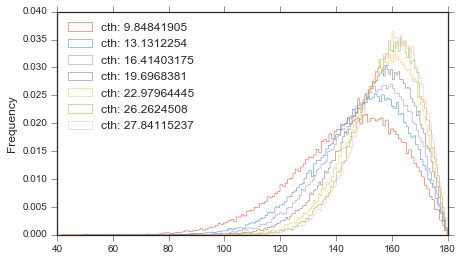

In [52]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(1,1,1)

groups = b.categories.groupby('cth')

for cth in sorted(groups.keys()):
    s = pd.concat(
        [pd.read_csv(csv.relpath, header=None, index_col=0) 
         for csv in groups[cth].loc['angles/sna_cg_cb.csv']])[1]

    s.plot.hist(bins=150, histtype='step', ax=ax, normed=True,
                label="cth: {}".format(cth))
    
ax.legend(loc='upper left')

## building domain-specific applications on datreant

[summary detail, probably a diagram, showing how Treants and Bundles
are able to work just fine with `Treant` subclasses]

## a growing development community

``datreant`` is a young project. There's plenty of room for new contributions at all levels.

## where we are going

Things I didn't talk about:

``datreant`` is a namespace package.

http://datreant.org

packages available on both PyPI and our Anaconda channel (datreant).

## acknowledgments